<a href="https://colab.research.google.com/github/VanshikaJain1601/test_repo/blob/master/MajorProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

USING GPU

In [ ]:
!nvidia-smi

Sun Jun 25 12:23:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

INSTALLING LIBRARIES FOR ACCELERATING LOADING PROCESS

In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.7 MB/s eta 0:00:00


FUNCTION FOR SELECTING PARAMETERS, INPUT PROMPT

In [ ]:
def Input():

  # taking input text for image generation
  print("ENTER TEXT PROMT: ", end = " ")
  prompt = input()
  print()

  # select the type of scheduler
  print("PRESS ONE OF THE FOLLOWING INDEXES FOR SELECTING A SCHEDULER")
  print("1. PNDM Scheduler")
  print("2. K-LMS Scheduler")
  print("3. Euler Discrete Scheduler")
  print("4. DPM Solver Multistep Scheduler")
  scheduler_no = int(input())

  scheduler = { 1: "PNDM Scheduler",
                2: "K-LMS Scheduler",
                3: "Euler Discrete Scheduler",
                4: "DPM Solver Multistep Scheduler"
              }
  for key in scheduler:
    if key == scheduler_no:
      sch = scheduler[key]
      break;
  print()

  # select the value of guidance scale
  print("ENTER CLASSIFIER-FREE GUIDANCE SCALE VALUE(Enter the value between 7 and 20): This parameter controls how much the image generation process",
        "follows the text prompt: ", end = " ")
  scale = int(input())

  return prompt, sch, scale


IMPORTING NECESSARY LIBRARIES FOR THE PIPELINE CONSTRUCTION AND OUTPUT

In [ ]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler, PNDMScheduler, DPMSolverMultistepScheduler, EulerDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image

In [ ]:
def Output(prompt, sch, scale):

  torch_device = "cuda" if torch.cuda.is_available() else "cpu"

  # 1. Load the autoencoder model which will be used to decode the latents into image space.
  vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")


  # 2. Load the tokenizer and text encoder to tokenize and encode the text.
  tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
  text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")


  # 3. The UNet model for generating the latents.
  unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

  # 4. Deciding the scheduler and number of inference steps for corresponding scheduler.
  if(sch == "K-LMS Scheduler"):
    scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
    num_inference_steps = 100

  elif(sch == "PNDM Scheduler"):
    scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
    num_inference_steps = 100

  elif(sch == "Euler Discrete Scheduler"):
    scheduler = EulerDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
    num_inference_steps = 80

  else:
    scheduler = DPMSolverMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
    num_inference_steps = 50


  # 5. Move the models to the GPU.
  vae = vae.to(torch_device)
  text_encoder = text_encoder.to(torch_device)
  unet = unet.to(torch_device)


  # 6. Parameters used to generate images.
  height = 512                        # default height of Stable Diffusion
  width = 512                         # default width of Stable Diffusion

  guidance_scale = scale              # Scale for classifier-free guidance

  generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

  batch_size = 1


  # 7. Getting text embeddings for the prompt. These embeddings will be used to condition the UNet model.
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]


  # 8. Getting the unconditional text embeddings for classifier-free guidance, which are just the embeddings for the padding token (empty text)
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]


  # 9. For classifier-free guidance, we need to do two forward passes. One with the conditioned input (text_embeddings), and another with the unconditional
  #    embeddings (uncond_embeddings). In practice, we can concatenate both into a single batch to avoid doing two forward passes.
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


  # 10. Generating intial random noise.
  latents = torch.randn( (batch_size, unet.in_channels, height // 8, width // 8), generator=generator)
  latents = latents.to(torch_device)

  scheduler.set_timesteps(num_inference_steps)

  latents = latents * scheduler.init_noise_sigma


  # 11. Denoising Loop
  i = 1
  for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

    if(i % 5 == 0):
      print(i, end = " ")
      lat = 1 / 0.18215 * latents

      with torch.no_grad():
        image = vae.decode(lat).sample

      image = (image / 2 + 0.5).clamp(0, 1)
      image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
      images = (image * 255).round().astype("uint8")
      pil_images = [Image.fromarray(image) for image in images]
      pil_images[0].show()
      pil_images[0].save("/content/images/image" + str(i) + ".jpg")

    i  = i+1


  EMPTYING CACHE

In [ ]:
torch.cuda.empty_cache()

MAIN EXECUTION

ENTER TEXT PROMT:  king fighting in front of castle

PRESS ONE OF THE FOLLOWING INDEXES FOR SELECTING A SCHEDULER
1. PNDM Scheduler
2. K-LMS Scheduler
3. Euler Discrete Scheduler
4. DPM Solver Multistep Scheduler
4

ENTER CLASSIFIER-FREE GUIDANCE SCALE VALUE(Enter the value between 7 and 20): This parameter controls how much the image generation process follows the text prompt:  9


The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.1.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.layer_norm1.weight', 'vision_model.encoder.layers.18.layer_norm1.weight', 'vision_model.encoder.layers.14.self_attn.v_proj.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.weight', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.11.mlp.fc1.weight', 'vision_model.encoder.layers.16.mlp.fc1.bias', 'vision_model.encoder.layers.10.layer_norm1.bias', 'vision_model.encoder.layers.10.layer_norm2.bias', 'vision_model.encoder.layers.14.self_attn.k_proj.bias', 'vision_model.encoder.layers.21.layer_norm2.bias', 'vision_model.encoder.laye

  0%|          | 0/50 [00:00<?, ?it/s]

5 

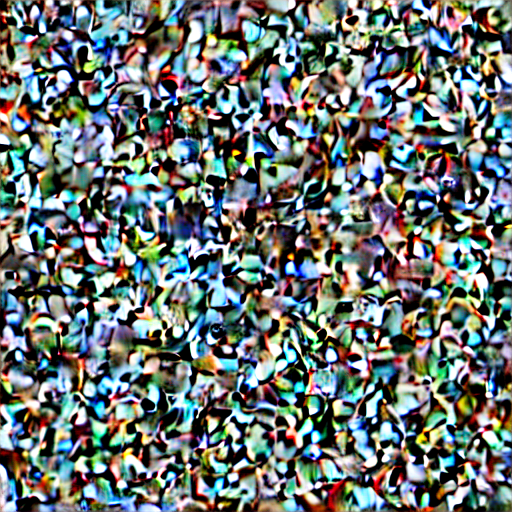

10 

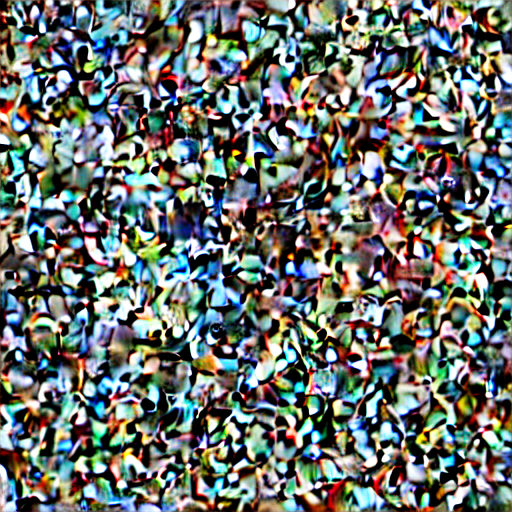

15 

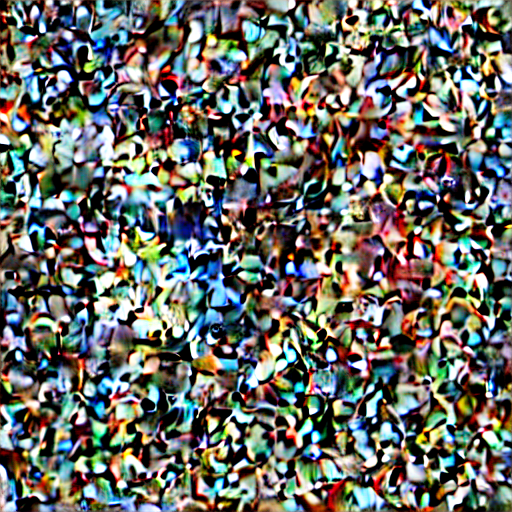

20 

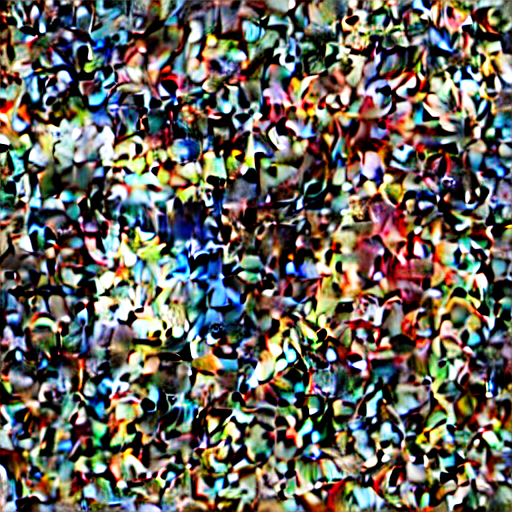

25 

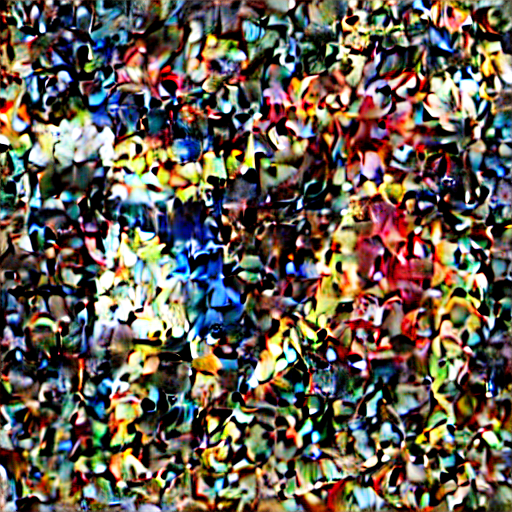

30 

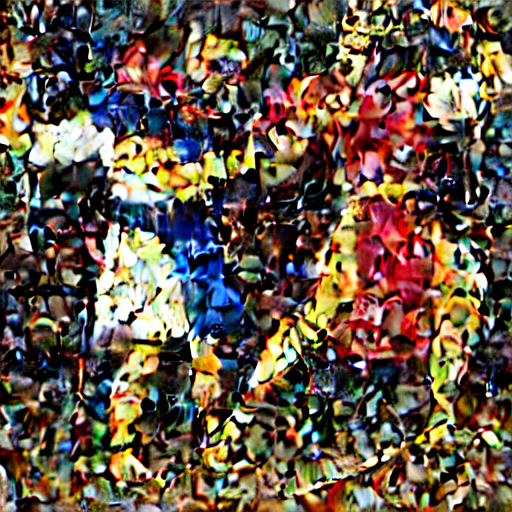

35 

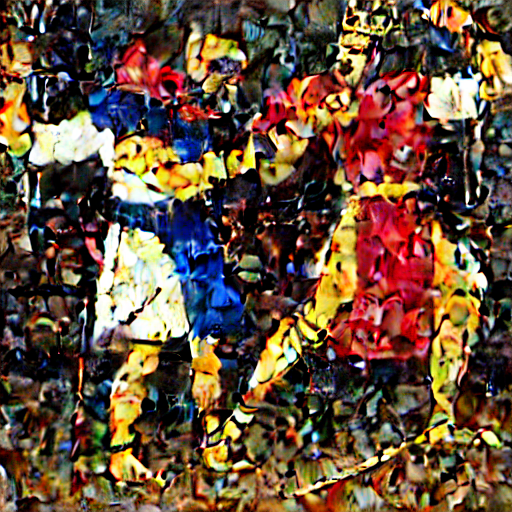

40 

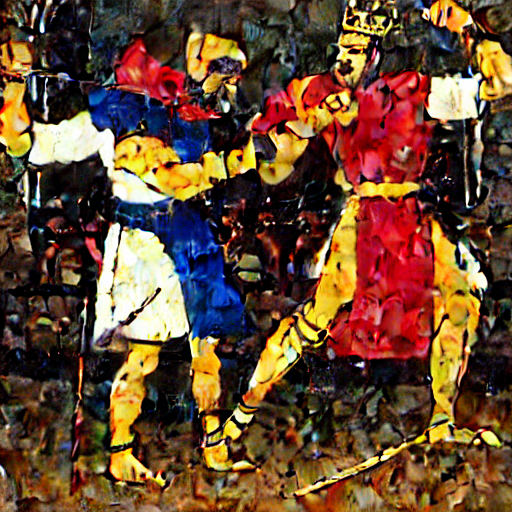

45 

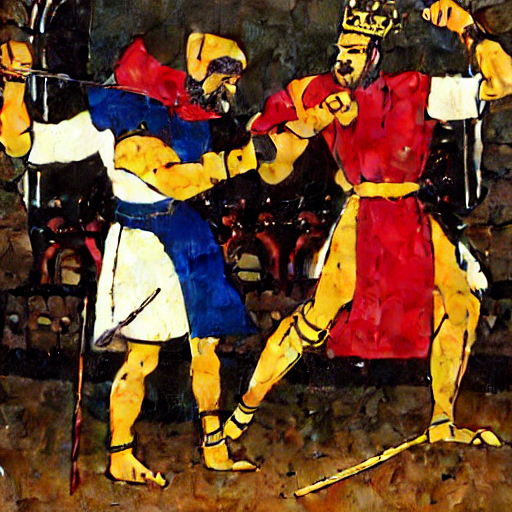

50 

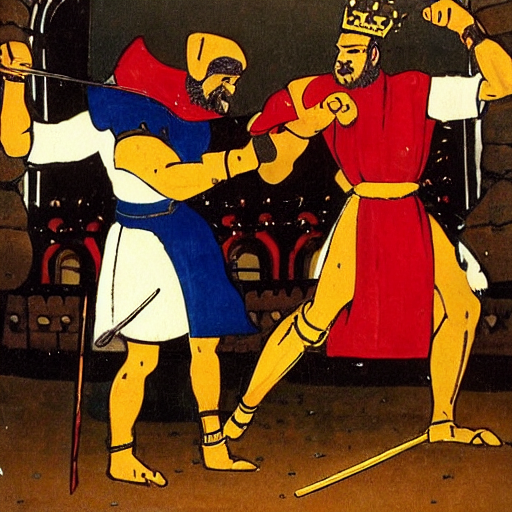

In [ ]:
prompt, sch, scale = Input()
Output(prompt, sch, scale)